# Parameters related to flights delays and cancellations

## Investigation Overview

In this investigation, I wanted to have an idea on some elements related to any flight delay or cancellation. So, for each of them, the main focus will be on the carriers, the destinations, the departure delays and the planned flight duration. 

## Dataset Overview

The data consisted of 73546 records of flights, for the US, over 5 years, from 1987 to 1992. There are time variables (mainly expected times and delays), numeric variables and text variables such are origins, destinations and carriers' names. We also have boolean like information to know if the flight is canceled or diverted.  
Those data files have been selected from [here](http://stat-computing.org/dataexpo/2009/the-data.html).   
A detailed presentation of the data is available [here](https://www.transtats.bts.gov/Fields.asp?Table_ID=236).   
As the original files were too big, I created a random sample of the original files I chose to use.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime, time

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load data files
df_1987 = pd.read_csv('data/1988_sample.csv')
df_1989 = pd.read_csv('data/1989_sample.csv')
df_1990 = pd.read_csv('data/1990_sample.csv')
df_1991 = pd.read_csv('data/1991_sample.csv')
df_1992 = pd.read_csv('data/1992_sample.csv')

# contains the association between airport real names and their IATA code
# collected from https://www.codediesel.com/data/international-airport-codes-download/
df_code = pd.read_csv('data/airport-codes.csv', names=['airport', 'Dest'])

In [4]:
# concat all into one dafaframe
df = pd.concat([df_1987, df_1989, df_1990, df_1991, df_1992], ignore_index=True)

In [5]:
# Make a copy of the original dataframe
df_flights = df.copy()

In [6]:
# Drop the columns where all elements are missing
df_flights.drop('TailNum', axis=1, inplace=True)
df_flights.drop('AirTime', axis=1, inplace=True)
df_flights.drop('TaxiIn', axis=1, inplace=True)
df_flights.drop('TaxiOut', axis=1, inplace=True)
df_flights.drop('CancellationCode', axis=1, inplace=True)
df_flights.drop('CarrierDelay', axis=1, inplace=True)
df_flights.drop('WeatherDelay', axis=1, inplace=True)
df_flights.drop('NASDelay', axis=1, inplace=True)
df_flights.drop('SecurityDelay', axis=1, inplace=True)
df_flights.drop('LateAircraftDelay', axis=1, inplace=True)

In [7]:
# create airline names-IATA codes dictionnary for the ones we need and know
airlines_dict = {'AA': 'American Airlines', 'UA': 'United Airlines', 'EA': 'Eastern', 'US': 'US Airways', 
                 'CO': 'Cobalt Air', 'NW': 'Northwest Airlines', 'TW': 'Tway Air', 'PI': 'Polar Airlines',
                'HP': 'Direktflyg', 'WN': 'Southwest Airlines', 'AS': 'Alaska Airlines', 'PS': 'Ukraine Airlines',
                'PA (1)': 'airblue', 'ML': 'Air Micronesia', 'ML (1)': 'Air Micronesia', 'PA': 'airblue',
                'DL': 'Delta Airlines'}

In [8]:
# Set carriers names according to the dictionnary
def set_carriername(row):
    if (row['UniqueCarrier'] in airlines_dict):
        return (airlines_dict.get(row['UniqueCarrier']))
    return

In [9]:
# set carriers names using the function above
df_flights['UniqueCarrier'] = df_flights.apply(set_carriername, axis=1)

In [10]:
# Test: which are the uniques values do we have now ?
df_flights['UniqueCarrier'].unique()

array(['United Airlines', 'American Airlines', 'Tway Air',
       'Delta Airlines', 'Eastern', 'Cobalt Air', 'US Airways',
       'Polar Airlines', 'Northwest Airlines', 'Southwest Airlines',
       'Direktflyg', 'airblue', 'Ukraine Airlines', 'Alaska Airlines',
       'Air Micronesia'], dtype=object)

In [11]:
# Destination airports names : do we have duplicates ?
sum(df_code.Dest.duplicated())

87

In [12]:
# drop duplicates based on the code
df_code.drop_duplicates(subset='Dest', inplace=True)

In [13]:
# Merge the airports' names with df_flights
# the new column 'airport' contains the names of the destinations airports
df_flights = pd.merge(df_flights, df_code, on='Dest')

In [14]:
# Set the "Cancelled" column type to boolean
df_flights['Cancelled'] = df_flights['Cancelled'].astype('bool')

In [15]:
# Set the "Year", "Month" and "DayOfMonth" to datetime
# Rename the needed columns for the datetime conversion
df_flights = df_flights.rename(columns={'Year': 'year', 'Month': 'month', 'DayofMonth': 'day'})

# Create a new column as the datetime
df_flights['timestamp'] = pd.to_datetime(df_flights[['year', 'month', 'day']])

In [16]:
# Drop the previous year, month, day columns we don't need anymore
df_flights.drop('year', axis=1, inplace=True)
df_flights.drop('month', axis=1, inplace=True)
df_flights.drop('day', axis=1, inplace=True)

## Occurences of the cancellations  

In [17]:
# Get the number of cancelled
cancelled = df_flights.query('Cancelled == True')['Cancelled'].count()
non_cancelled = df_flights.shape[0] - cancelled

We have a very low 1.1% of cancelled flights, which indeed is still important in the flight industry.

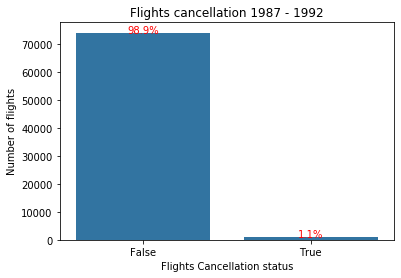

In [18]:
# Create a bar chart of the cancelation state
# Use only one color
base_color = sb.color_palette()[0]

# plot the bar chart
cancelled_bar = sb.countplot(data = df_flights, x = 'Cancelled', color = base_color)

# Set labels names
cancelled_bar.set(title='Flights cancellation 1987 - 1992', xlabel='Flights Cancellation status', ylabel='Number of flights')

# label the frequencies on the bars
# First, calculate non cancelled percentage
non_cancelled_percent = '{:0.1f}%'.format(100*non_cancelled/df_flights.shape[0])

# calculate the cancelled percentage
cancelled_percent = '{:0.1f}%'.format(100*cancelled/df_flights.shape[0])

# Set the labels names on the bars
plt.text(0, non_cancelled-8, non_cancelled_percent, ha = 'center', color = 'r')
plt.text(1, cancelled-8, cancelled_percent, ha = 'center', color = 'r');

### Per cities

In [19]:
# Get the cancelled flight dataframe
df_cancelled = df_flights[df_flights['Cancelled'] == True]

In [20]:
# Get the top 7 and 5 cities with the most cancellations
first_5_cities = df_cancelled.airport.value_counts().head(5).keys().tolist()
first_7_cities = df_cancelled.airport.value_counts().head(7).keys().tolist()

In [21]:
# restrict the plot to those cities for a better analysis
# this is a specific dataframe for the plot
df_cancelled_cities = df_cancelled.query('airport in @first_7_cities')

Visually, the destination city with the most cancelled flights is Chicago. US Airways is the carrier with the most cancelled flights.

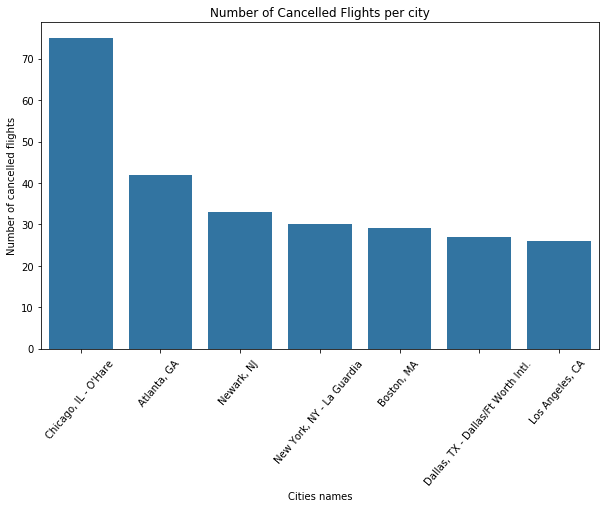

In [22]:
# Set the size bigger
plt.figure(figsize = [10, 6])

# Use only one single color
base_color = color = sb.color_palette()[0]

# sort
cat_order = df_cancelled_cities['airport'].value_counts().index

# plot the bar chart
cancelled_cities_plot = sb.countplot(data = df_cancelled_cities, x = 'airport', color = base_color, order = cat_order)

# set the titles
cancelled_cities_plot.set(title='Number of Cancelled Flights per city', xlabel='Cities names', ylabel='Number of cancelled flights')

# rotate the labels
cancelled_cities_plot.set_xticklabels(cancelled_cities_plot.get_xticklabels(), rotation=50);

### Per carriers

The winner is US which is "US Airways" ! followed by United Airlines and American Airlines.

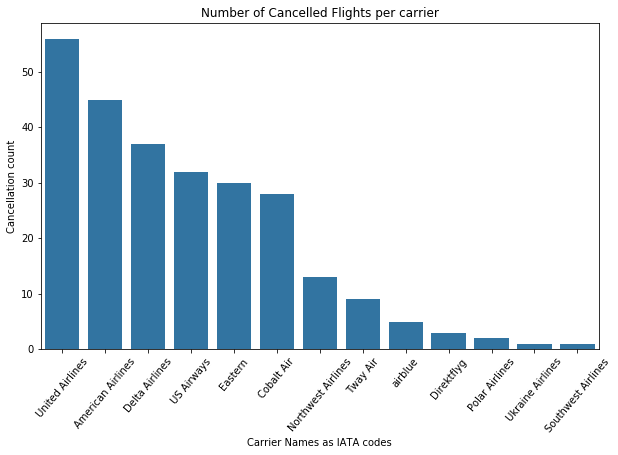

In [23]:
# Set the size bigger
plt.figure(figsize = [10, 6])

# Use only one single color
base_color = color = sb.color_palette()[0]

# sort
cat_order = df_cancelled_cities['UniqueCarrier'].value_counts().index

# plot the bar chart
cancelled_carrier_plot = sb.countplot(data = df_cancelled_cities, x = 'UniqueCarrier', color = base_color, order = cat_order)

# set titles
cancelled_carrier_plot.set(title='Number of Cancelled Flights per carrier', xlabel='Carrier Names as IATA codes', ylabel='Cancellation count')

# rotate the labels on x axis
cancelled_carrier_plot.set_xticklabels(cancelled_carrier_plot.get_xticklabels(), rotation=50);

## Distribution of arrival delays

In [24]:
# Get a copy of the dataframe we started to clean
df_completed_flights = df_flights.copy()

In [25]:
# Now we delete the rows where at least one element is missing
df_completed_flights.dropna(inplace=True)

The distribution was right skewed. An appropriate bin width and a zoom on the main bulk of the data through the use of axis limits led to focus on the main delays which are all aronud zero. Visually from -40 minutes to 0 excluded, meaning arrival in advance, and from 0 excluded to 80 minutes, meaning arrival late.

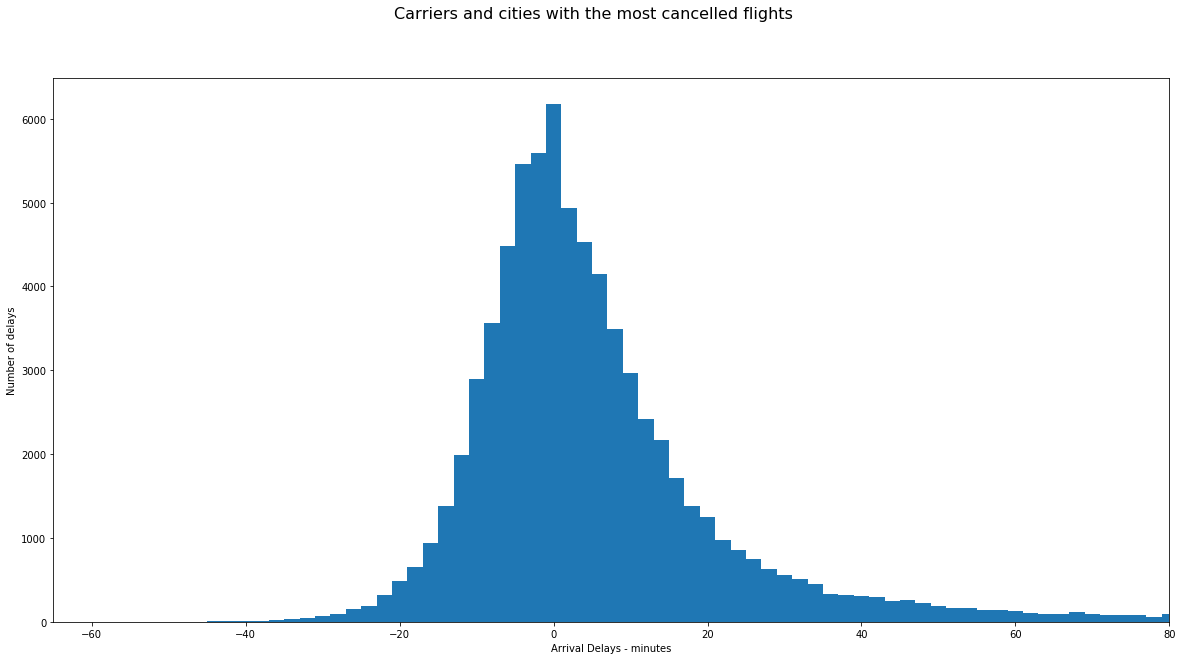

In [26]:
# tentative for a better zoom selection
# set the figures sizes
fig = plt.figure(figsize = [20, 10])

# Set the title
fig.suptitle('Carriers and cities with the most cancelled flights', fontsize=16)

# Set an appropriate bin width
bin_edges = np.arange(df_completed_flights['ArrDelay'].min(), df_completed_flights['ArrDelay'].max()+2, 2)

# plot the data
plt.hist(data = df_completed_flights, x = 'ArrDelay', bins = bin_edges)

# set the  x values limitation for the 2nd histogram. I start at the min() and use 70 as the right limit
plt.xlim((df_completed_flights['ArrDelay'].min(), 80))

# set x and y axis labels
plt.ylabel('Number of delays');
plt.xlabel('Arrival Delays - minutes'); 

## Cancelled flights : destinations vs carriers codes

Considering that these are not numeric variables, there is no variation between the features but just an accumulation of points each time we have an association.   

In [27]:
# Create a dataframe for the top 5 and 7 cancelled destinations

# Create the dataframe
df_5_cancelled = df_cancelled.query('airport in @first_5_cities')
df_7_cancelled = df_cancelled.query('airport in @first_7_cities')

Here are the observed relationships between the carriers and the cities with the most cancelled flights :  
- For Chicago arrival airport, American Airlines and United Airlines are the carriers with the most cancelled flights.   
- For Boston arrival airport, US Airways is the winner.   
- For New York arrival airport, US Airways is also the one with the most cancelled flights.   
- For Atlanta arrival airport, Easten Airlines and Delta Airlines are the carriers with the most cancelled flights.  

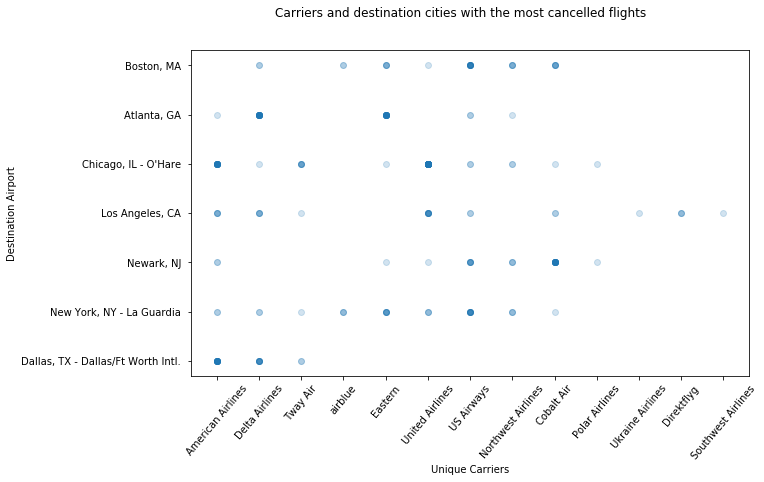

In [28]:
# Set the plot size
fig = plt.figure(figsize = [10, 6])

# use the jitter from reglot
plt.scatter(data = df_7_cancelled, x = 'UniqueCarrier', y='airport', alpha = 1/5)

# Set the title
fig.suptitle('Carriers and destination cities with the most cancelled flights', fontsize=12)

# set x and y labels
plt.xlabel('Unique Carriers')
plt.ylabel('Destination Airport')

# rotate labels on x axis
plt.xticks(rotation=50);

## Delayed flights : destinations vs carriers codes

We have a lot of cities. So we plot the first 20 top cities where there are the most delayed flights.  

In [29]:
# focus on the cities where ArrDelay > 0
df_delayed = df_completed_flights.query('ArrDelay > 0')

In [30]:
# Get the first 20 top cities where we have the most delayed flights
delayed_topcities = df_delayed.airport.value_counts().head(20).keys().tolist()

In [31]:
# Create a dataframe for those cities
df_delayed_topcities = df_delayed.query('airport in @delayed_topcities')

For all the arrival cities with delays, here the top five careers which are the mostly late : AA (American Airlines), TW (Trans World Airlines), US (US Airways), DL (Delta Airlines), UA (United Airlines).

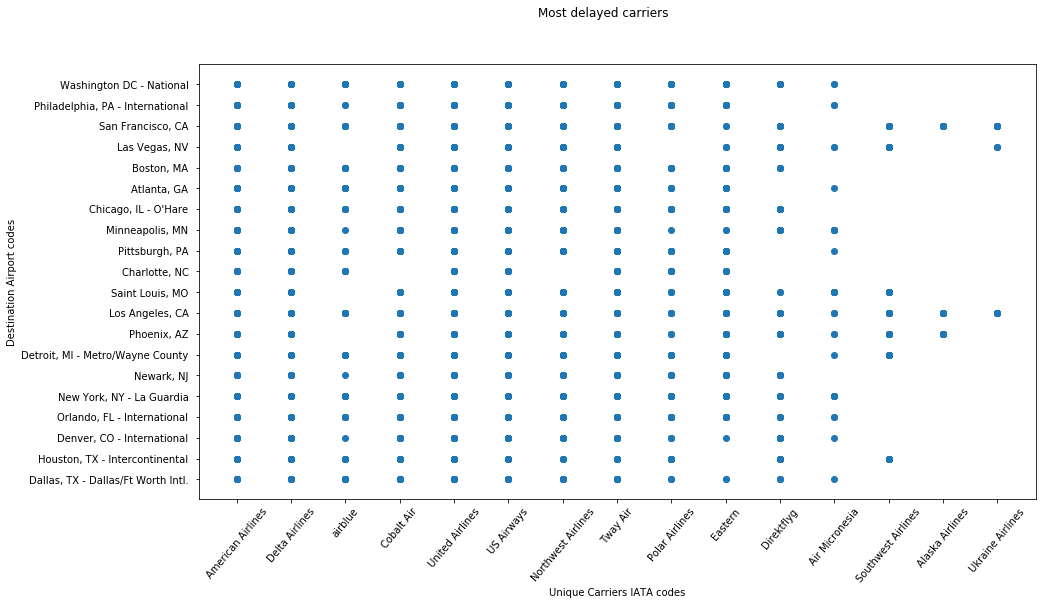

In [32]:
# Relationship between top 5 arrival cities for delays and carriers

# set the graph size
fig = plt.figure(figsize = [15, 8])

# scatterplot
plt.scatter(data = df_delayed_topcities, x = 'UniqueCarrier', y = 'airport')

# set x and y labels
plt.xlabel('Unique Carriers IATA codes')
plt.ylabel('Destination Airport codes')

# Set the plot title
fig.suptitle('Most delayed carriers', fontsize=12)

# rotate labels on x axis
plt.xticks(rotation=50);

## Cancelled flights : destinations vs carriers codes and planned flights durations
  
For airlines, distances (and consequently flights durations) are organized along short-haul, medium-haul and long-haul flights. We choose here :

    short-haul flights : flights duration <= 120 min
    medium-haul flights : 5h >= flights duration > 120 min
    long-haul flights : flights duration > 5h

- Eastern and Delta Airlines cancelled flights were mostly planned for to Atlanta. The majority of them were short and medium-haul flights.
- American Airlines and United Airlines cancelled flights were mostly planned for Chicago. Here we had short and medium-haul flights too. 

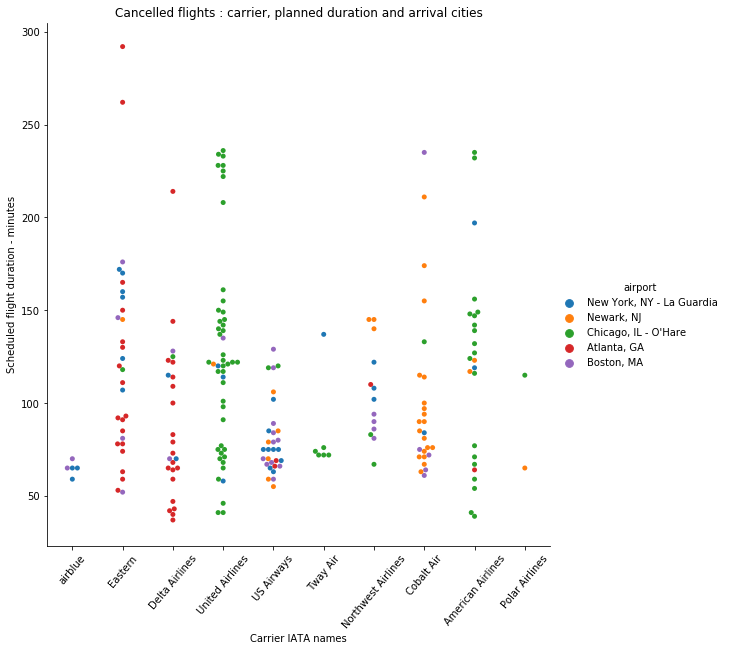

In [33]:
# plot the 3 variables : carrier (UniqueCarrier, scheduled flight duration(CRSElapsedTime) and destination (Dest)
myplot = sb.catplot(x="UniqueCarrier", y="CRSElapsedTime", kind="swarm", data=df_5_cancelled, hue='airport', height=8)

# Set the titles
myplot.set(title='Cancelled flights : carrier, planned duration and arrival cities', xlabel='Carrier IATA names', ylabel='Scheduled flight duration - minutes')

# rotate labels on x axis
myplot.set_xticklabels(rotation=50);

## Delayed flights : destinations vs carriers codes and departure delays



There is a confirmation regarding Atlanta and Chicago : most of the flights delayed on arrival for those airports, left their origin airports with a delay too.  
It is quite interesting to see that for mostly all the carriers, their flights heading to Los Angeles were delayed on departure.

In [34]:
# Get the first 6 top cities where we have the most delayed flights
delayed_fivecities = df_delayed.airport.value_counts().head(6).keys().tolist()

In [35]:
# Create a dataframe for those cities
df_delayed_fivecities = df_delayed.query('airport in @delayed_fivecities')

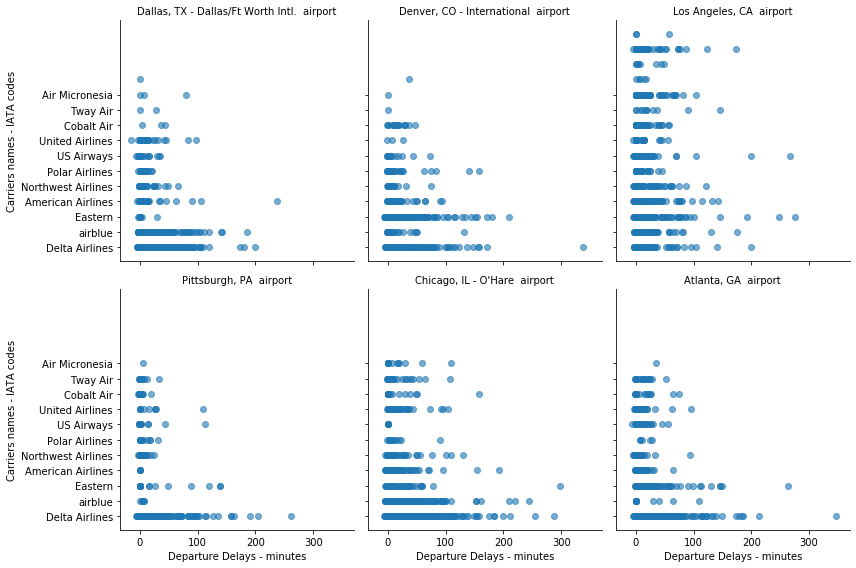

In [36]:
# plot the 3 variables : carrier (UniqueCarrier, departure delay (DeDelay) and destination (Dest)

# I use faceting by airport
deplayedplot = sb.FacetGrid(df_delayed_fivecities, col = 'airport', col_wrap = 3, size = 4)

# Each graph is a categorical for departure delays and carrier name
deplayedplot.map(plt.scatter, 'DepDelay', 'UniqueCarrier', alpha = 3/5)

# set the axis labels
deplayedplot.set_axis_labels("Departure Delays - minutes", "Carriers names - IATA codes");

# set each facet title with the airport name and "airport" keyword
deplayedplot.set_titles("{col_name} {col_var}");